### Step 1 — Start from consistent-resolution CMB maps

- **Space:** real/pixel space on the sphere (HEALPix maps \(T(\hat{n})\))
- **Input:** SILC temperature maps for \(N = 1, 2, 3, 4, 5\) (each already homogenized to an effective \(5'\) Gaussian beam during preprocessing), and the SMICA map.
- **Output:** same maps, ready for masking (still real space, HEALPix)


In [18]:
import numpy as np
import healpy as hp
import s2fft

def mw_alm_2_hp_alm(MW_alm, lmax):
    '''MW_alm: 2D array of shape (Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
    '''
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
        
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]

    return hp_alm


def hp_alm_2_mw_alm(hp_alm, L_max):
    """
    Converts spherical harmonics (alm) to a matrix representation for use in MW sampling.

    This function takes 1D Healpix spherical harmonics coefficients (alm) and converts them into a matrix form 
    that is in (MW sampling, McEwen & Wiaux) sampling. The matrix form is complex-valued 
    and indexed by multipole moment and azimuthal index.

    Parameters:
        hp_alm (numpy.ndarray): The input healpix spherical harmonics coefficients (alm).
        L_max (int): The maximum multipole moment to be represented in the output matrix.
    
    Note: # L_max = 4 | l = 0,1,2,3 , true lmax is L_max-1 = 3 | m = -3...0...(L_max-1 = 3)| number of m = 2(L_max-1)+1 = 2L_max-1

    Returns:
        MW_alm (numpy.ndarray): 2D array of shape (Lmax, 2*Lmax-1) MW spherical harmonics coefficients 
    """

    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]

    return MW_alm

In [19]:
import healpy as hp

# after ILC_wav_coeff_maps_MP finishes for one realization:

component = 'CSNT'
component_name = 'cmb'
realization = "0000"  # string

# path to synthesized MW map
mw_path = f"ILC/synthesized_ILC_MW_maps/{component}_ILC_MW_Map_cilc_{component_name}_R{realization}_MP.npy"

# load MW pixel map
MW_pix = np.load(mw_path)

# if s2fft expects shape (1, ...), take first slice
if MW_pix.ndim == 3:
    MW_pix = MW_pix[0]

L = MW_pix.shape[0]
lmax = L - 1

# MW pixel → MW alm
MW_alm = s2fft.forward(MW_pix, L=L)

# MW alm → HP alm (your existing function)
hp_alm = mw_alm_2_hp_alm(MW_alm, lmax)

# choose nside for given lmax
nside = 2048

# HP alm → HP map
hp_map = hp.alm2map(hp_alm, nside=nside, lmax=lmax, verbose=False)

# save to FITS
hp.write_map(f"{component}_cILC_{component_name}_R{realization}.fits", hp_map, overwrite=True)

print(f"Saved HEALPix map to {component}_cILC_{component_name}_R{realization}.fits")


setting the output map dtype to [dtype('float64')]


Saved HEALPix map to CSNT_cILC_cmb_R0000.fits


### Step 2 — Apply the point-source mask

- **Space:** real/pixel space (multiply map by mask)  
- **Input:** map from Step 1 + point-source mask  
- **Output:** masked map $M(\hat{n})\,T(\hat{n})$ (used because Fig. 13(a) shows **point-source** masked spectra)


In [20]:
'''
import requests
# URLs for Planck point-source masks
urls = {
    "LFI": "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=LFI_Mask_PointSrc_2048_R2.00.fits",
    "HFI": "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_PointSrc_2048_R2.00.fits"
}


# Download masks if not already present
for name, url in urls.items():
    filename = f"{name}_Mask_PointSrc_2048.fits"
    try:
        with open(filename, "wb") as f:
            f.write(requests.get(url).content)
        print(f"Downloaded {filename}")
    except Exception as e:
        print(f"Error downloading {name} mask: {e}")
'''

'\nimport requests\n# URLs for Planck point-source masks\nurls = {\n    "LFI": "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=LFI_Mask_PointSrc_2048_R2.00.fits",\n    "HFI": "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_PointSrc_2048_R2.00.fits"\n}\n\n\n# Download masks if not already present\nfor name, url in urls.items():\n    filename = f"{name}_Mask_PointSrc_2048.fits"\n    try:\n        with open(filename, "wb") as f:\n            f.write(requests.get(url).content)\n        print(f"Downloaded {filename}")\n    except Exception as e:\n        print(f"Error downloading {name} mask: {e}")\n'

In [21]:
'''     
# Load your estimated CMB map (HEALPix)
map_T = hp.read_map("CSNT_cILC_cmb_R0000.fits", verbose=False)

# Load LFI and HFI masks
mask_LFI = hp.read_map("LFI_Mask_PointSrc_2048.fits")
mask_HFI = hp.read_map("HFI_Mask_PointSrc_2048.fits")

print("map_T:", map_T.size, "nside=", hp.get_nside(map_T))
print("mask_LFI:", mask_LFI.size, "nside=", hp.get_nside(mask_LFI))
print("mask_HFI:", mask_HFI.size, "nside=", hp.get_nside(mask_HFI))

# Combine masks: intersection (product) keeps only pixels unmasked in both
mask_combined = mask_LFI * mask_HFI

# Apply mask in pixel space
masked_map = mask_combined * map_T

# Save the masked map
hp.write_map("masked_map.fits", masked_map, overwrite=True)


# visualize_MW_Pix_map(masked_map, title="Masked CMB Map", coord=["G"], unit="K", is_MW_alm=False)
# Optional: visualise
hp.mollview(masked_map, title="CMB Map with Planck Point-Source Mask")
'''

'     \n# Load your estimated CMB map (HEALPix)\nmap_T = hp.read_map("CSNT_cILC_cmb_R0000.fits", verbose=False)\n\n# Load LFI and HFI masks\nmask_LFI = hp.read_map("LFI_Mask_PointSrc_2048.fits")\nmask_HFI = hp.read_map("HFI_Mask_PointSrc_2048.fits")\n\nprint("map_T:", map_T.size, "nside=", hp.get_nside(map_T))\nprint("mask_LFI:", mask_LFI.size, "nside=", hp.get_nside(mask_LFI))\nprint("mask_HFI:", mask_HFI.size, "nside=", hp.get_nside(mask_HFI))\n\n# Combine masks: intersection (product) keeps only pixels unmasked in both\nmask_combined = mask_LFI * mask_HFI\n\n# Apply mask in pixel space\nmasked_map = mask_combined * map_T\n\n# Save the masked map\nhp.write_map("masked_map.fits", masked_map, overwrite=True)\n\n\n# visualize_MW_Pix_map(masked_map, title="Masked CMB Map", coord=["G"], unit="K", is_MW_alm=False)\n# Optional: visualise\nhp.mollview(masked_map, title="CMB Map with Planck Point-Source Mask")\n'

**Step 3 — Go to harmonic space (pseudo-spectrum)**

- **Space:** harmonic space (spherical harmonics)  
- **Input:** masked map $M(\hat{n})\,T(\hat{n})$ 
- **Operation:** spherical-harmonic transform $\Rightarrow$ coefficients $\tilde{a}_{\ell m}$; compute pseudo-spectrum $\tilde{C}_{\ell}$  
- **Output:** $\tilde{C}_{\ell}$ (pseudo-$C_{\ell}$)  


In [22]:
'''
import numpy as np
import healpy as hp

map_T = hp.read_map("CSNT_cILC_cmb_R0000.fits", verbose=False)
masked_map = map_T 

# masked_map = W * T  (HEALPix 1D array)
nside = hp.get_nside(masked_map)
lmax  = 3*nside - 1

# 1) Harmonic coefficients of the masked map:  a~_{lm}
alm_tilde = hp.map2alm(masked_map, lmax=lmax, iter=0)

# 2) Build C~_ell via eq. (13): sum over m of |a~_{lm}|^2
#    Healpy stores m >= 0 only; for real maps use:
#    sum_{m=-l}^l |a_{lm}|^2 = |a_{l0}|^2 + 2 * sum_{m=1}^l |a_{lm}|^2
ell_arr, m_arr = hp.Alm.getlm(lmax)                  # arrays of l and m for each alm index
abs2 = np.abs(alm_tilde)**2                          # |a~_{lm}|^2
weights = np.ones_like(abs2)
weights[m_arr > 0] = 2.0                             # double m>0 terms

sum_by_ell = np.bincount(ell_arr, weights=weights*abs2, minlength=lmax+1)

ell = np.arange(lmax + 1)
Cl_tilde = sum_by_ell / (2*ell + 1)                  # eq. (13) pseudo-spectrum

# (optional) quick f_sky correction
# fsky = float(mask.mean()); Cl_est = Cl_tilde / fsky
'''

'\nimport numpy as np\nimport healpy as hp\n\nmap_T = hp.read_map("CSNT_cILC_cmb_R0000.fits", verbose=False)\nmasked_map = map_T \n\n# masked_map = W * T  (HEALPix 1D array)\nnside = hp.get_nside(masked_map)\nlmax  = 3*nside - 1\n\n# 1) Harmonic coefficients of the masked map:  a~_{lm}\nalm_tilde = hp.map2alm(masked_map, lmax=lmax, iter=0)\n\n# 2) Build C~_ell via eq. (13): sum over m of |a~_{lm}|^2\n#    Healpy stores m >= 0 only; for real maps use:\n#    sum_{m=-l}^l |a_{lm}|^2 = |a_{l0}|^2 + 2 * sum_{m=1}^l |a_{lm}|^2\nell_arr, m_arr = hp.Alm.getlm(lmax)                  # arrays of l and m for each alm index\nabs2 = np.abs(alm_tilde)**2                          # |a~_{lm}|^2\nweights = np.ones_like(abs2)\nweights[m_arr > 0] = 2.0                             # double m>0 terms\n\nsum_by_ell = np.bincount(ell_arr, weights=weights*abs2, minlength=lmax+1)\n\nell = np.arange(lmax + 1)\nCl_tilde = sum_by_ell / (2*ell + 1)                  # eq. (13) pseudo-spectrum\n\n# (optional) quick 

In [23]:
import numpy as np
import healpy as hp

map_T = hp.read_map("CSNT_cILC_cmb_R0000.fits", verbose=False)
masked_map = map_T 

Cl = hp.anafast(map_T, lmax=lmax)  

**Step 4 — First-order mask correction (small mask)**

- **Space:** harmonic space (scalar sequence vs. $\ell$)  
- **Input:** $\tilde C_\ell$, sky fraction $f_{\rm sky}$  
- **Operation:** because the mask is small, divide by $f_{\rm sky}$ (they use $f_{\rm sky}=0.978$)  
- **Output:** $\hat C_\ell \approx \tilde C_\ell / f_{\rm sky}$ (mask-corrected estimate)


In [24]:
'''
import numpy as np

# Inputs you already have:
#   Cl_tilde      # pseudo-spectrum from Step 3
#   mask_combined # same NSIDE as the map (binary or apodized)

# Pick f_sky
#is_binary = np.all((np.isclose(mask_combined, 0.0)) | (np.isclose(mask_combined, 1.0)))
#fsky = float(mask_combined.mean()) if is_binary else float(np.mean(mask_combined**2))
# If you want to force the paper's value instead:
fsky = 0.978

# First-order mask correction (small-mask approximation)
Cl_hat = Cl_tilde / fsky  # ≈ full-sky estimate

# (optional) save
# np.savez("step4_mask_corrected.npz", Cl_hat=Cl_hat, fsky=fsky)
print(f"f_sky = {fsky:.6f}")
'''

'\nimport numpy as np\n\n# Inputs you already have:\n#   Cl_tilde      # pseudo-spectrum from Step 3\n#   mask_combined # same NSIDE as the map (binary or apodized)\n\n# Pick f_sky\n#is_binary = np.all((np.isclose(mask_combined, 0.0)) | (np.isclose(mask_combined, 1.0)))\n#fsky = float(mask_combined.mean()) if is_binary else float(np.mean(mask_combined**2))\n# If you want to force the paper\'s value instead:\nfsky = 0.978\n\n# First-order mask correction (small-mask approximation)\nCl_hat = Cl_tilde / fsky  # ≈ full-sky estimate\n\n# (optional) save\n# np.savez("step4_mask_corrected.npz", Cl_hat=Cl_hat, fsky=fsky)\nprint(f"f_sky = {fsky:.6f}")\n'

**Step 5 — Ensure common resolution (beam/pixel window)**

- **Space:** harmonic space  
- **Input:** $\hat C_\ell$, effective beam $B_\ell$ (5′ Gaussian), pixel window $P_\ell$  
- **Operation:** deconvolve so spectra correspond to the same effective beam/pixelization: $C_\ell^{\text{sky}}=\hat C_\ell/(B_\ell^{2}P_\ell^{2})$. Maps were already homogenized to $5'$ in the pipeline (§3.3), so this step is the spectral counterpart of that homogenization.  
- **Output:** $C_\ell^{\text{sky}}$ at common resolution


In [31]:
# --- STEP 5: deconvolve standard beam + pixel window from the ILC spectrum ---

import numpy as np
import healpy as hp

# you already have: map_T (your final ILC HEALPix map) and lmax
nside = hp.get_nside(map_T)
lmax_use = min(lmax, 3*nside - 1)

# raw full-sky spectrum from the ILC map
Cl_hat = hp.anafast(map_T, lmax=lmax_use)

# standard beam (5 arcmin) and pixel window of this map
fwhm_rad = np.deg2rad(5.0/60.0)              # change if your ILC used a different target FWHM
Bl       = hp.gauss_beam(fwhm_rad, lmax=lmax_use, pol=False)
Pell     = hp.pixwin(nside, lmax=lmax_use, pol=False)

# deconvolve to get the sky spectrum referenced to no beam/pixel smoothing
den      = (Bl**2) * (Pell**2)
Cl_sky   = np.zeros_like(Cl_hat)
mask_ok  = den > 0
Cl_sky[mask_ok] = Cl_hat[mask_ok] / den[mask_ok]
Cl_sky[~mask_ok] = np.nan  # guard against divide-by-zero at extreme ell if any
'''
# optional: save
np.save(f"Cl_sky_{component}_cILC_{component_name}_R{realization}.npy", Cl_sky)
np.save(f"Dl_sky_{component}_cILC_{component_name}_R{realization}.npy", Dl)
'''
print ('Cl_sky:',Cl_sky)
print("Step 5 done: deconvolved Cl_sky saved.")


Cl_sky: [8.42592673e-14 3.11845464e-26 1.02159908e-09 ... 1.24390393e-18
 3.84849556e-19 1.25630484e-18]
Step 5 done: deconvolved Cl_sky saved.


**Step 6 — Convert to $D_\ell$ and plot**

- **Space:** harmonic space  
- **Input:** $C_\ell$ (per method: SILC $N=1..5$, SMICA)  
- **Operation:** $D_\ell \equiv \ell(\ell+1)\,C_\ell/(2\pi)$  
- **Output (what you see in Fig. 13a):** curves of $D_\ell$ for each method; overplotted with the **Planck 2015** best-fit ΛCDM theory curve used throughout the paper.


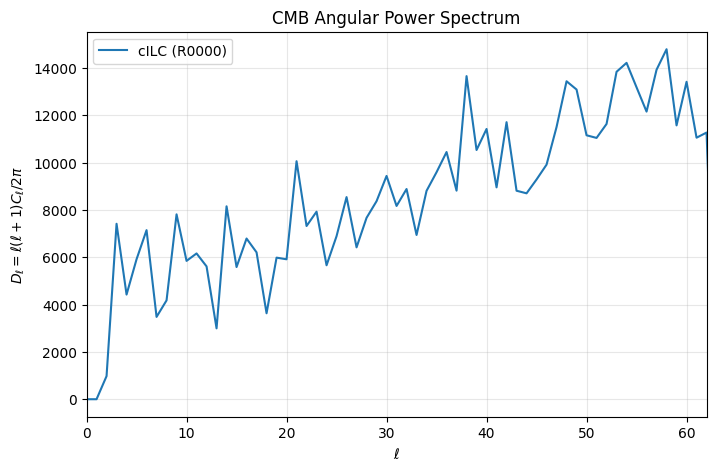

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# Example: read in your final ILC map and compute Cℓ
map_T = hp.read_map("CSNT_cILC_cmb_R0000.fits", verbose=False)
nside = hp.get_nside(map_T)
lmax = 3 * nside - 1

# Compute angular power spectrum
Cl = hp.anafast(map_T, lmax=lmax)

# Convert to Dℓ
ell = np.arange(len(Cl))
Dl = (ell * (ell + 1) * Cl / (2 * np.pi)) * 1e12 # in unit of 

# Plot
plt.figure(figsize=(8,5))
plt.plot(ell, Dl, label="cILC (R0000)")

# (Optional) add other methods if you have their Cl arrays
# plt.plot(ell, Dl_SILC, label="SILC N=1")
# plt.plot(ell, Dl_SMICA, label="SMICA")

plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell = \ell(\ell+1)C_\ell / 2\pi$")
#plt.title("CMB Angular Power Spectrum")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0,62)  # adjust as needed
plt.show()
